# Wavelet and orientation

## Introduction

This notebook is the code that is used to study the impact on wavelet-based radiomics model performance caused by differences in orientation of the inputs in the training and testing data. The motivation of the study is to identify potential issues of current radiomics pipeline that considered wavelet decomposition as an ordinary filter. The authors argue that a robust radiomics model should be independent of the input orientation

## Workflow of study

```mermaid
flowchart TD
    Input[(Input)] --> train_cohort[(Training set)] & test_cohort[("Testing set (R_0)")]
    test_cohort --> aug(Augmentation) --> aug_sets[("R_10, R_20, R_40, R_80")]
    
```

## Required packages

* numpy
* scipy
* SimpleITK
* pandas
* mnts (https://github.com/alabamagan/mri_normalization_tools)

In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import SimpleITK as sitk
import pandas as pd
from scipy.spatial import transform
from mpl_toolkits.mplot3d import Axes3D
from typing import *
from IPython.display import *
from pathlib import Path

# Used to ensure repeatability
global_rand_seed = 285758975

# define for easy usage
mdprint = lambda x: display(Markdown(x))

# add package to path without installing it
sys.path.append("./")
from feature_robustness_analysis.rot_aug.im_ops import *
from feature_robustness_analysis.rot_aug.rot_ops import *

# List out the version of the packages required
np_ver = np.__version__
sp_ver = scipy.__version__
sitk_ver = sitk.__version__
pd_ver = pd.__version__
display({
    'Numpy version': np_ver, 
    'Scipy version': sp_ver, 
    'SITK version': sitk_ver,
    'Pandas version': pd_ver
})

{'Numpy version': '1.24.3',
 'Scipy version': '1.10.1',
 'SITK version': '2.2.1',
 'Pandas version': '2.0.1'}

# Processing NSCLC public data

The CT public dataset is downloaded from TCIA database and used to conduct this study. **Note that intensity normalization should have been done.**

## Handling samples with multiple lesions

There are several patients with multiple lesions and this study consider each lesion a single data point. Patients with mulitple lesions are identified using the `ConnectedComponentFilter`, with a minimal threshold of 30 pixels to remove clutters. In addition, lesions with only 1 axial slices (3mm in thickness) is also removed from analysis to avoid over interpretation with 3D features. 

## Excluded

* Case LUNG1-128 is excluded because segmentation is not available
* Case LUNG1-245 is excluded because of mismatch in data dimension and segmentation

In [6]:
import re
from mnts.utils.filename_globber import *

'''Configurations'''
data_root = Path("Data/NSCLC/")
# Normalized data are stored here
img_dir = data_root.joinpath("02.Normalized_Images/ZScore")
seg_dir = data_root.joinpath("0B.SEGMENT_ALL/GTV-1")
idregpat = "^([\w\d]+-\d+)" # For pairing the IDs

# exclude list
exclude_pids = ['LUNG1-128', 'LUNG1-246']

## Paring the images and segmentation

Using `mnts` methods, the original NSCLC data were converted to NIFTI files. The naming system was based on the patient
code "LUNG1-XXX". The segmentation was saved in the same format as well, and they are paired by using `re` package.

## Calculating the center of mass

The images are first cropped into 3D patches encapsulating a single lesion. There could be multiple lesions per patient.
Therefore, we first found out how many lesions there are by looking at the connected components. Then, the center of 
mass of each lesion are computed as coordinates. 

In [8]:
"""Calculating the center of masses of lesions. This cell will take a while to compute"""

# Image files for globbing pids
files = [str(r.name) for r in img_dir.glob("*.nii.gz")]
pids = get_unique_IDs(files, idregpat)

# exclude
for p in exclude_pids:
    if p in pids:
        pids.remove(p)

# create the id mapping
img_list, tar_list = load_supervised_pair_by_IDs(str(img_dir), str(seg_dir), pids, globber=idregpat)
img_list = pd.Series(data=img_list, index=pids, name='Images')
tar_list = pd.Series(data=tar_list, index=pids, name='Segmentations')
df_idmappings = pd.concat([img_list, tar_list], axis=1)

# for each row, get center of masses
com_series = pd.Series(name='COM', dtype=str)
num_of_label_series = pd.Series(name='Number of lesions', dtype=int)
for key, seg_file in df_idmappings['Segmentations'].items():
    _seg_path = seg_dir.joinpath(seg_file)
    _seg = sitk.ReadImage(str(_seg_path))
    _seg_conn = get_connected_bodies(_seg)
    
    num_of_labels = len(_seg_conn)
    _com_list = []
    for _sc in _seg_conn:
        _com = get_cent_of_mass(_sc)
        _bounding_box = get_bounding_box(_sc)
        _com_list.append((_com, _bounding_box))
    com_series[key] = _com_list
    num_of_label_series[key] = len(_seg_conn)
    
df = pd.concat([df_idmappings, com_series, num_of_label_series], axis=1)
mdprint("# Center of masses")
display(df)

[2024-01-06 18:55:46,759-INFO] (global) Loging to /media/storage/Source/Local/ipython/tmpg9aqfpmh.log with log level: 20
[2024-01-06 18:55:46,759-INFO] (global) Created first logger. Exception hooked to this logger. Log level is: info
[2024-01-06 18:55:46,760-INFO] (default) Loging to /media/storage/Source/Local/ipython/tmpg9aqfpmh.log with log level: 20
[2024-01-06 18:55:46,760-INFO] (default) Requesting logger [algorithm.utils] not exist, creating...
[2024-01-06 18:55:46,760-INFO] (algorithm.utils) Loging to /media/storage/Source/Local/ipython/tmpg9aqfpmh.log with log level: 20


# Center of masses

,Images,Segmentations,COM,Number of lesions
LUNG1-001,LUNG1-001-Missing+0.nii.gz,LUNG1-001-Segmentation+300_GTV-1.nii.gz,"[((82.30074532053526, -201.48105435025894, -45...",1
LUNG1-002,LUNG1-002-Missing+1.nii.gz,LUNG1-002-Segmentation+300_GTV-1.nii.gz,"[((-74.47025678716594, 16.355618635968504, -18...",1
LUNG1-003,LUNG1-003-Missing+1.nii.gz,LUNG1-003-Segmentation+300_GTV-1.nii.gz,"[((47.42720699680901, -2.4607800757946747, -12...",1
LUNG1-004,LUNG1-004-Missing+0.nii.gz,LUNG1-004-Segmentation+300_GTV-1.nii.gz,"[((59.82698099398604, 80.81240635855703, -557....",1
LUNG1-005,LUNG1-005-Missing+1.nii.gz,LUNG1-005-Segmentation+300_GTV-1.nii.gz,"[((-58.78786734478716, 5.099882393388968, -15....",1
...,...,...,...,...
LUNG1-418,LUNG1-418-Missing+0.nii.gz,LUNG1-418-Segmentation+300_GTV-1.nii.gz,"[((57.32439171943225, -145.95976964605273, -40...",3
LUNG1-419,LUNG1-419-Missing+0.nii.gz,LUNG1-419-Segmentation+300_GTV-1.nii.gz,"[((-76.55753803907983, -207.93668661304113, -4...",1
LUNG1-420,LUNG1-420-Missing+0.nii.gz,LUNG1-420-Segmentation+300_GTV-1.nii.gz,"[((54.15286421869259, -121.5744590908783, -519...",1
LUNG1-421,LUNG1-421-Missing+0.nii.gz,LUNG1-421-Segmentation+300_GTV-1.nii.gz,"[((59.817097819498265, -168.61503094308367, -4...",1


# Sampling rotations

To simulate orientation variations, we sampled rotations from normal distributions with 10, 20, 40 and 80 mean and 10 degrees standard deviation.

In [15]:
# Get Euler angle rotational matrix. intrinsic rotation. yaw then pitch
R = lambda yaw, pitch: transform.Rotation.from_euler('ZX', [yaw, pitch], degrees=True)

# number of cases
size = len(df)

# sample the rotations and convert them to affine matrices
target_mean_phi = (10, 20, 40) # in degrees
def gen_afftine_mat(deg):
    Rset = gen_rot_set(size, pitch_mu=deg, pitch_sigma=10, yaw_mu=0, yaw_sigma=deg)
    Rset = rot_to_affine(Rset, [np.array(v[0][0]) for v in df['COM'].values])
    Rset = {key: r for key, r in zip(df.index, Rset)}
    return Rset
# Sample rotation for each lesion
rotations = {deg: gen_afftine_mat(deg) for deg in target_mean_phi}
print(rotations)


{10: {'LUNG1-001': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe9d449f2d0> >, 'LUNG1-002': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe92a6f0090> >, 'LUNG1-003': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe92a4f1f60> >, 'LUNG1-004': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe92a4f1d20> >, 'LUNG1-005': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe92a6f0990> >, 'LUNG1-006': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe92a6f0fc0> >, 'LUNG1-007': <SimpleITK.SimpleITK.AffineTransform; proxy of <Swig Object of type 'itk::simple::AffineTransform *' at 0x7fe92a923330> >, 'LUNG1-008': <SimpleITK.SimpleITK.AffineTr

## Illustration of rotations

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.03778832e-02
  -9.53831593e-02  9.95232031e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.09124987e-02
   3.56893420e-01  9.32756669e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.84836491e-02
  -2.08900290e-01  9.77762253e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.97423582e-03
  -2.19794142e-01  9.75541741e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.45867358e-05
  -2.67872731e-01  9.63454306e-01]]


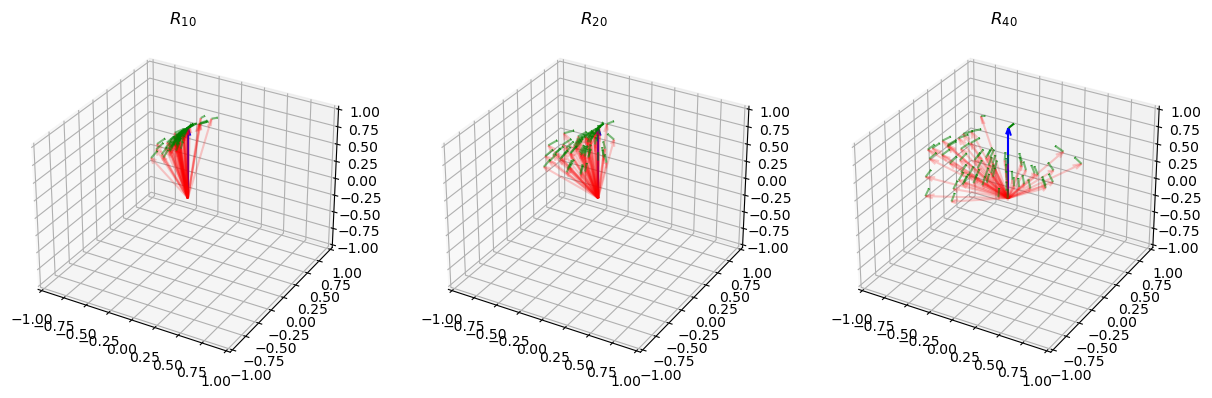

In [101]:
# Sample some illustration rotations
illustration_degs = (10, 20, 40)
illustration_rots ={deg:gen_rot_set(64, pitch_mu=deg, pitch_sigma=10, yaw_mu=0, yaw_sigma=deg) for deg in illustration_degs}

# set up reference
reference_ori = np.array([0, 0, 0, 0, 0, 1])
reference_vec = np.array([0, 0, 1, 0, 0.1, 0]) # small vector serving as orientation reference

# apply the rotations
rotated_ori = {deg: [np.concatenate([reference_ori[:3], trans.apply(reference_ori[3:])]) 
                     for trans in illustration_rots[deg]] 
               for deg in illustration_rots}
rotated_vec = {deg: [np.concatenate([trans.apply(reference_vec[:3]), trans.apply(reference_vec[3:])]) 
                     for trans in illustration_rots[deg]] 
               for deg in illustration_rots}

fig = plt.figure(figsize=(len(illustration_degs) * 5,5))
for i, deg in enumerate(illustration_degs):
    ax = fig.add_subplot(1,len(illustration_degs),i+1, projection='3d')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    
    ax.quiver(*np.stack(rotated_ori[deg]).T, arrow_length_ratio=0.1, color='red', alpha=0.2)
    ax.quiver(*np.stack(rotated_vec[deg]).T, arrow_length_ratio=0.1, color='green', alpha=0.5)
    ax.quiver(*reference_ori, arrow_length_ratio=0.1, color='blue')
    ax.quiver(*reference_vec, arrow_length_ratio=0.1, color='green')
    ax.set_title("$R_{" + str(deg) + "}$")

# plt.show()


# Applying rotations and resampling

In [ ]:
# Load image and segmentation pairs
selected_img, selected_seg = load_supervised_pair_by_IDs(str(img_dir), str(seg_dir), df.index, globber=idregpat)

# Define output directories and make sure they exist
output_dir = data_root.joinpath("10.WaveletStudyData/")
imgpatch_outdir = output_dir.joinpath("A.ImgPatches")
segpatch_outdir = output_dir.joinpath("B.SegPatches")
imgpatch_outdir.mkdir(exist_ok=True, parents=True)
segpatch_outdir.mkdir(exist_ok=True)

# Iterate over all patient IDs, image paths and segmentation paths
for _pid, _img_p, _seg_p in zip(df.index, selected_img, selected_seg):
    print(_pid)
    
    # Read image and segmentation files
    _img = sitk.ReadImage(str(img_dir.joinpath(_img_p)))
    _seg = sitk.ReadImage(str(seg_dir.joinpath(_seg_p)))
    
    num_of_lesions = df.loc[_pid]['Number of lesions']
    
    # If a patient has more than one lesion
    if num_of_lesions > 1:
        _seg_conn = get_connected_bodies(_seg)
        
        # If the number of connected segments doesn't match the number of lesions, raise an error
        if len(_seg_conn) != num_of_lesions:
            raise IndexError(f"Number of segmentation components specified is incorrect for {_pid}: {_seg_p}")
        
        # Iterate over each connected segment
        for i, _sc in enumerate(_seg_conn):
            _new_pid = _pid + f'-{chr(i + 65)}'
            print(_new_pid)
            
            # Save the un-rotated image
            _img_out, _seg_out = resample_to_segment_bbox(_img_out, _sc, padding=10)
            _imgfname = imgpatch_outdir.joinpath(f"{_new_pid}_R0.nii.gz")
            _segfname = segpatch_outdir.joinpath(f"{_new_pid}_R0.nii.gz")
            
            # If the file already exists, skip this step
            if _imgfname.is_file():
                print("Skipping R0...")
            else:
                sitk.WriteImage(_img_out, str(_imgfname))
                sitk.WriteImage(_seg_out, str(_segfname))
                
            # Rotate and save image
            for deg in rotations:
                print(deg)
                _imgfname = imgpatch_outdir.joinpath(f"{_new_pid}_R{deg}.nii.gz")
                _segfname = segpatch_outdir.joinpath(f"{_new_pid}_R{deg}.nii.gz")
                if _imgfname.is_file():
                    continue
                
                _transform = rotations[deg][_new_pid]
                _img_out = resample_image(_img, _transform)
                _seg_out = resample_image(_sc, _transform)
                _img_out, _seg_out = resample_to_segment_bbox(_img_out, _seg_out, padding=10)
                
                # Write the rotated image
                sitk.WriteImage(_img_out, str(_imgfname))
                sitk.WriteImage(_seg_out, str(_segfname))
    else:    
        # If a patient has only one lesion, follow this process
        _img_out, _seg_out = resample_to_segment_bbox(_img_out, _seg, padding=10)
        _imgfname = imgpatch_outdir.joinpath(f"{_new_pid}_R0.nii.gz")
        _segfname = segpatch_outdir.joinpath(f"{_new_pid}_R0.nii.gz")
        if _imgfname.is_file():
            print("Skipping R0...")
        else:
            sitk.WriteImage(_img_out, str(_imgfname))
            sitk.WriteImage(_seg_out, str(_segfname))   
        
        # Rotate and save image for the case of one lesion
        for deg in rotations:
            _imgfname = imgpatch_outdir.joinpath(f"{_pid}_R{deg}.nii.gz")
            _segfname = segpatch_outdir.joinpath(f"{_pid}_R{deg}.nii.gz")
            if _imgfname.is_file():
                print("Skipping...")
                continue
            
            _transform = rotations[deg][_pid]
            _img_out = resample_image(_img, _transform)
            _seg_out = resample_image(_seg, _transform)
            _img_out, _seg_out = resample_to_segment_bbox(_img_out, _seg_out, padding=10)

            # Write the rotated image
            sitk.WriteImage(_img_out, str(_imgfname))
            sitk.WriteImage(_seg_out, str(_segfname))